Epoch 0, Loss: 1.9552
Epoch 50, Loss: 0.6252
Epoch 100, Loss: 0.5576
Epoch 150, Loss: 0.5183
Epoch 200, Loss: 0.4882
Epoch 250, Loss: 0.4652
Epoch 300, Loss: 0.4461
Epoch 350, Loss: 0.4306
Epoch 400, Loss: 0.4287
Epoch 450, Loss: 0.4198
Test Accuracy: 0.7267


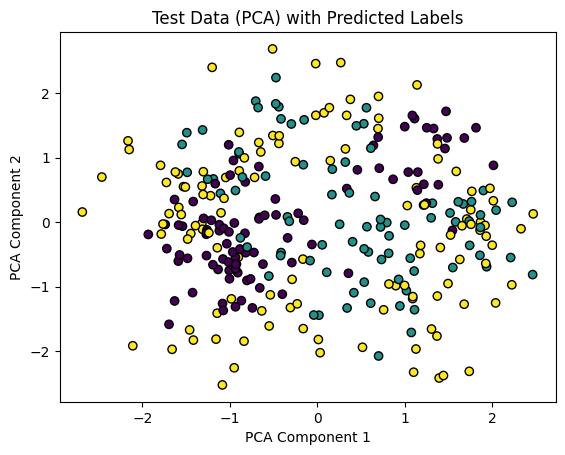

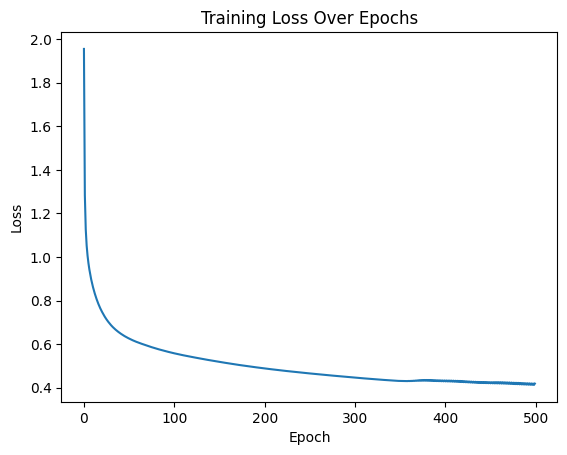

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data generation
X0, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=2, random_state=42, class_sep=2.0)
y0 = np.zeros(500)
X1, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=3, random_state=43, class_sep=2.0)
y1 = np.ones(500)
X2, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=4, random_state=44, class_sep=2.0)
y2 = np.full(500, 2)
X = np.vstack((X0, X1, X2))
y = np.hstack((y0, y1, y2))
y_one_hot = np.zeros((y.size, 3))
y_one_hot[np.arange(y.size), y.astype(int)] = 1

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

class MLP:
    def __init__(self, input_size=4, hidden_size1=64, hidden_size2=32, output_size=3, lr=0.1):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2 / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2 / hidden_size2)
        self.b3 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.h2 = self.relu(self.z2)
        self.z3 = self.h2 @ self.W3 + self.b3
        self.y_hat = self.softmax(self.z3)
        return self.y_hat
    
    def compute_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y * np.log(y_hat), axis=1))
    
    def backward(self, X, y, y_hat):
        N = X.shape[0]
        dL_dz3 = (y_hat - y) / N
        dL_dW3 = self.h2.T @ dL_dz3
        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)
        dL_dh2 = dL_dz3 @ self.W3.T
        dL_dz2 = dL_dh2 * self.relu_derivative(self.z2)
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        # Gradient clipping
        max_grad = 1.0
        dL_dW1 = np.clip(dL_dW1, -max_grad, max_grad)
        dL_dW2 = np.clip(dL_dW2, -max_grad, max_grad)
        dL_dW3 = np.clip(dL_dW3, -max_grad, max_grad)
        # Update parameters
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=500):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            self.backward(X, y, y_hat)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

# Train and evaluate
mlp = MLP(input_size=4, hidden_size1=64, hidden_size2=32, output_size=3, lr=0.1)
losses = mlp.train(X_train, y_train, epochs=500)
y_pred = mlp.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualizations
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='viridis', edgecolors='k')
plt.title('Test Data (PCA) with Predicted Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()